---
title: Bloch-Redfield and Redfield Failing for degenerate Hamiltonians
date: 2024-08-08
authors:
  - name: Gerardo Suarez
---

### In The SYK model:

Inspired by the steady state of this dissipator being the maximally entangled state let us construct a qubit entangler out of it

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import syk_full,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve,redfield

In [2]:
N=2
seeds=list(range(42,52))
k=7
H,psis=syk_full(N,seed=seeds[k])

The Hamiltonian in this example is then given  by

In [3]:
H=H/np.max(H.full()) #energy rescaling
w1=0
w2=0
g=-1
H=(w1*tensor(sigmaz(),qeye(2)) + w2*tensor(qeye(2),sigmaz()) +g*tensor(sigmaz(),sigmaz()))
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

While the coupling operator to the bath is simply 

$Q= \sum_{i} a_{i} \psi_{i}$

Where each $a_{i}$ is a real number, randomly generated from a Gaussian

In [4]:
Q=sum([psis[i]*np.sqrt(2) for i in range(len(psis))])
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.+0.j  1.-1.j  1.-1.j  0.+0.j]
 [ 1.+1.j  0.+0.j  0.+0.j -1.+1.j]
 [ 1.+1.j  0.+0.j  0.+0.j  1.-1.j]
 [ 0.+0.j -1.-1.j  1.+1.j  0.+0.j]]

We consider the initial state to be 

In [5]:
N=2
state_list = [(basis(2, 0)+basis(2,1))/np.sqrt(2)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = tensor(state_list)#+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)
rho0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.5 0.  0. ]
 [0.5 0.5 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]

In [6]:
from qutip import concurrence

In [7]:
concurrence(rho0)

0.0

In [8]:
E01=H.eigenenergies()[1]-H.eigenenergies()[0]#it is mostly degenerate, this does not help much
w0=10 #*E01*5#since I have no g parameter then It doesn't scale uniformingly as ising
gamma=0.5*10#w0/2 
Gamma=gamma
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)

And consider an underdamped spectral density at zero temperature with $\gamma=${eval}`gamma` , $\lambda=${eval}`lam` ,$\omega_{0}=${eval}`w0`. After fitting the correlation function one obtains

In [9]:
from qutip.core import UnderDampedEnvironment
from qutip.solver.heom import BosonicBath

In [10]:
bath =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
env,fitinfo= bath.approx_by_cf_fit(tfit,Ni_max=1,Nr_max=3,target_rsme=None,maxfev=1e8)
bath=BosonicBath.from_environment(env,Q)
bath.T=0
print(fitinfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 3 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-1.04e-01 |-9.53e+00 |3.27e-10                           | 1         |-4.47e-01 |-2.50e+00 |9.68e+00                            
 2         |-7.02e+00 |-2.42e+00 |9.13e+00                           |                                                                      
 3         | 7.50e+00 |-2.44e+00 |9.16e+00                           |A normalized RMSE of  1.52e-07 was obtained for the the i

In [11]:
times2 = np.linspace(0,40,500)
cvis = bath.correlation_function(times2)

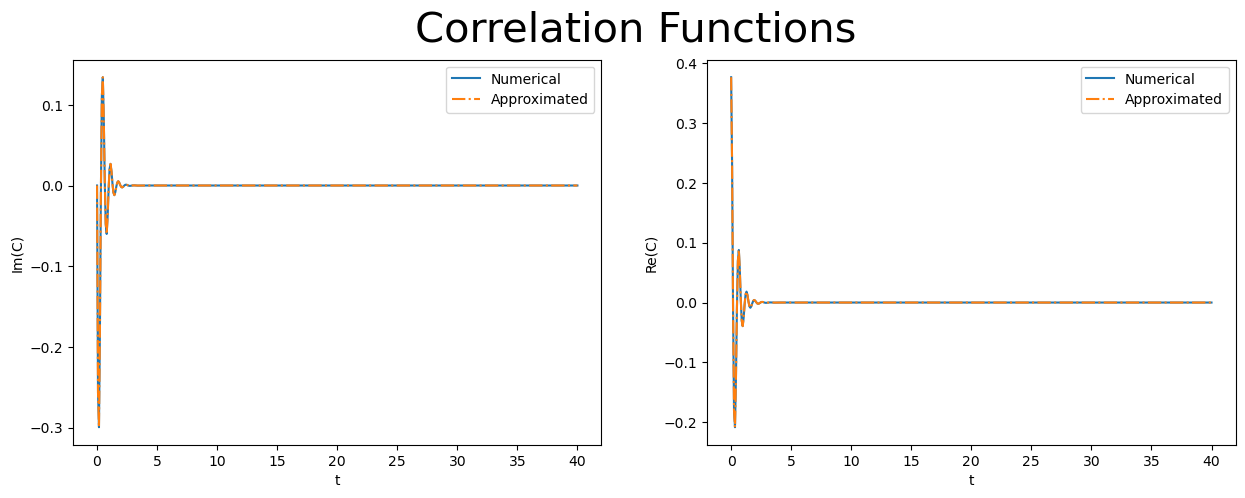

In [12]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath.correlation_function(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath.correlation_function(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [48]:
def solve_dynamics(H,Q,bath,bath1,rho0,depth=5,levels=8,modes=2,times=times):
    print("============================")
    print("Solving HEOM")
    print("============================")
    solver = heom.HEOMSolver(H,
                          [bath1], max_depth=depth, options={"atol": 1e-14})
    result = solver.run(rho0, times)
    print("============================")
    print("HEOM Done")
    print("============================")
    print("============================")
    print("Solving Cumulant")
    print("============================")
    bath.bose=None
    cum = csolve(
        Hsys=H, t=times, baths=[bath],
        Qs=[Q],
        eps=1e-6, cython=False,matsubara=True)
    
    result_cum = cum.evolution(rho0)
    
    result_cum = rotation(result_cum, H, times)
    print("============================")
    print("Cumulant Done")
    print("============================")
    print("============================")
    print("Solving Redfield")
    print("============================")
    red=redfield.redfield(Hsys=H, t=times, baths=[bath1],
    Qs=[Q],
    eps=1e-12,matsubara=True)
    result_red = red.evolution(rho0)
    result_red = [Qobj(i) for i in result_red]
    for i in result_red:
        i.dims=H.dims
    result_red = rotation(result_red, H, times)
    print("============================")
    print("Redfield Done")
    print("============================")
    print("============================")
    print("Solving Bloch-Redfield")
    print("============================")
    a_ops = [[Q, bath]]
    resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
        "rtol": 1e-12}, sec_cutoff=-1)
    
    print("============================")
    print("Bloch-Redfield Done")
    print("============================")
    print("============================")
    # print("Solving Global")
    # print("============================")
    # global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4
    # c_ops2=[Qobj((np.sqrt(bath.power_spectrum(k))*v).data) for k, v in global_one.items()]
    # for i in range(len(c_ops2)):
    #     c_ops2[i].dims=H.dims 
    # result_lindblad_global2 = mesolve(H, rho0, times, c_ops2)
    # print("============================")
    # print("Global Done")
    # print("============================")
    # print("============================")
    # print("Solving Pseudomodes")
    # print("============================")
    # Ncutoff=levels
    # bathu = zero_temp_bath(tfit, lam, gamma, w0, N=modes)
    # print(bathu.fitinfo["summary"])
    # example = pseudomode(Hsys=H, Q=Q, bath=bathu)
    # ans = example.evolution(rho0, Ncutoff, times, options={
    #                     "atol": 1e-14, "normalize_output": False, "store_states": True})
    # ans = [i.ptrace(range(N))for i in ans.states]
    # print("============================")
    # print("Pseudomodes done")
    # print("============================")
    results=[result,result_cum,resultBR,result_red]#,result_lindblad_global2,result_red]
    return results

In [49]:
times=np.linspace(0,150,500)
results_syk=solve_dynamics(H,Q,bath,bath,rho0,times=times)

Solving HEOM
10.0%. Run time:   1.00s. Est. time left: 00:00:00:08
20.0%. Run time:   1.98s. Est. time left: 00:00:00:07
30.1%. Run time:   3.01s. Est. time left: 00:00:00:06
40.1%. Run time:   4.03s. Est. time left: 00:00:00:06
50.1%. Run time:   5.05s. Est. time left: 00:00:00:05
60.1%. Run time:   6.11s. Est. time left: 00:00:00:04
70.1%. Run time:   7.12s. Est. time left: 00:00:00:03
80.2%. Run time:   8.14s. Est. time left: 00:00:00:02
90.2%. Run time:   9.18s. Est. time left: 00:00:00:00
100.0%. Run time:  10.27s. Est. time left: 00:00:00:00
Total run time:  10.27s
HEOM Done
Solving Cumulant


Calculating time dependent generators: 100%|██████████| 4/4 [00:00<00:00, 508.66it/s]
Computing Exponential of Generators . . . .: 500it [00:00, 590.66it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.11305618286132812
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.0034685134887695312
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:5.160625219345093
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done


In [ ]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()


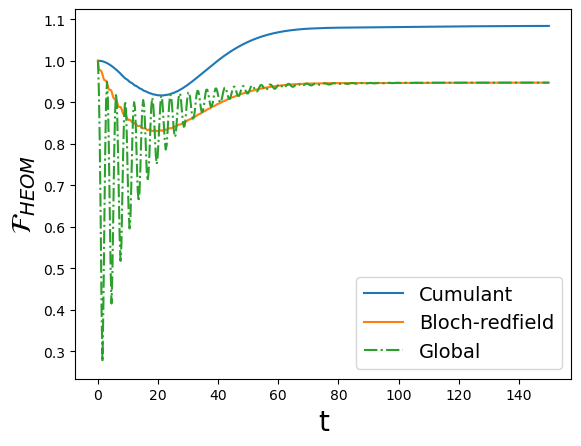

In [ ]:
plot_fidelities(results_syk,H,times)

In [ ]:
def trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$TR_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

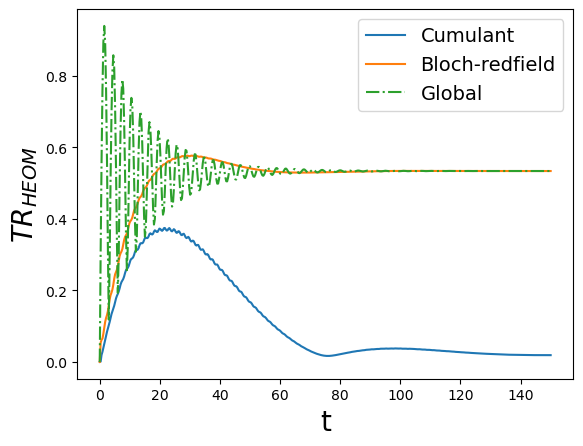

In [ ]:
trd(results_syk,H,times)

## Steady states (Not really steady but at $t=50$)

## HEOM

In [ ]:
from qutip import concurrence

In [ ]:
results_syk[0].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.74773470e-01+3.22100709e-11j  4.17294625e-04-3.66713104e-03j
   6.67325803e-07+2.39009005e-05j -1.07279734e-11+2.58247907e-01j]
 [ 4.17294622e-04+3.66713104e-03j -2.47585950e-02-3.21975424e-11j
  -8.26278175e-03-1.07408822e-11j  2.39009004e-05+6.67325843e-07j]
 [ 6.67325842e-07-2.39009004e-05j -8.26278175e-03-1.07403520e-11j
  -8.26278175e-03-1.07410838e-11j  2.39009004e-05+6.67325842e-07j]
 [ 1.07283717e-11-2.58247907e-01j  2.39009005e-05-6.67325803e-07j
   2.39009005e-05-6.67325803e-07j  2.58247907e-01+1.07287918e-11j]]

In [ ]:
import qutip as qt

In [ ]:
def negativity(rho):
    eig=[i for i in qt.partial_transpose(rho,[0,1]).eigenenergies() if i<0]
    return abs(sum(eig))

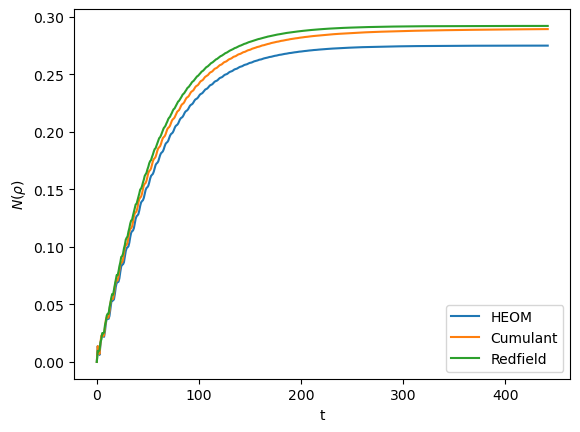

In [ ]:
plt.plot(lam*times,[negativity(i) for i in results_syk[0].states],label="HEOM")
plt.plot(lam*times,[negativity(i) for i in results_syk[1]],label="Cumulant")
plt.plot(lam*times,[negativity(i) for i in results_syk[3]],label="Redfield")
plt.xlabel("t")
plt.ylabel(r"$N(\rho)$")
plt.legend()
plt.show()

## Cumulant

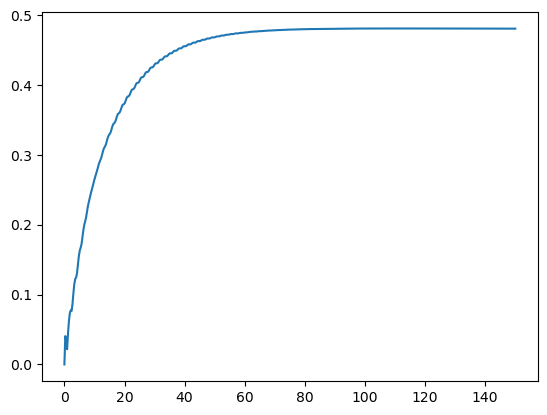

In [22]:
plt.plot(times,[concurrence(i) for i in results_syk[1]])

## Bloch-Redfield

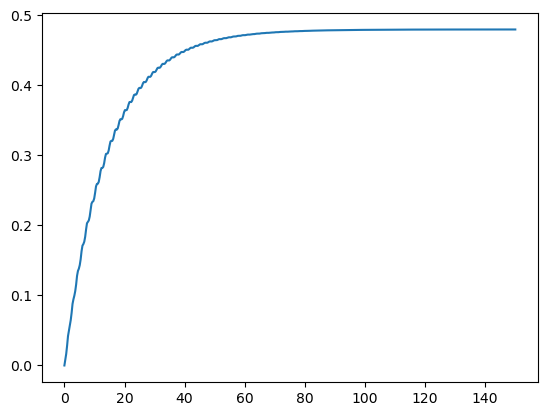

In [23]:
plt.plot(times,[concurrence(i) for i in results_syk[2].states])

From what we see in both the trace distance and fidelity plots, the Bloch-Redfield approach does terribly when we consider this scenario (multiple implementations where checked). Notice that this issue seems to be about the coupling operator, rather than the Hamiltonian. 

## Every Equation is ok
Consider a different coupling operator just the majorana fermion denoted by the index 0 coupled to the environment or in the notes notation ($b_{0}=-i$,$b_{1}=0$)

In [24]:
Q2=psis[0]*np.sqrt(2)
Q2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]]

In [25]:
bath = UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
env,fitinfo= bath.approx_by_cf_fit(tfit,Ni_max=1,Nr_max=2,target_rsme=None)
bath=BosonicBath.from_environment(env,Q2)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         | 4.63e-01 |-2.56e+00 |9.66e+00                           | 1         |-4.47e-01 |-2.50e+00 |9.68e+00                            
 2         |-8.49e-02 |-9.15e+00 |3.96e-08                           |                                                                      
                                                                     |A normalized RMSE of  1.52e-07 was obtained for the the i

In [26]:
results_syk2=solve_dynamics(H,Q2,bath,bath,rho0,modes=3)

Solving HEOM
10.1%. Run time:   0.68s. Est. time left: 00:00:00:06
20.2%. Run time:   1.23s. Est. time left: 00:00:00:04
30.3%. Run time:   1.67s. Est. time left: 00:00:00:03
40.4%. Run time:   2.03s. Est. time left: 00:00:00:02
50.5%. Run time:   2.38s. Est. time left: 00:00:00:02
60.6%. Run time:   2.73s. Est. time left: 00:00:00:01
70.7%. Run time:   3.07s. Est. time left: 00:00:00:01
80.8%. Run time:   3.43s. Est. time left: 00:00:00:00
90.9%. Run time:   3.75s. Est. time left: 00:00:00:00
100.0%. Run time:   4.07s. Est. time left: 00:00:00:00
Total run time:   4.07s
HEOM Done
Solving Cumulant


Calculating time dependent generators: 100%|██████████| 4/4 [00:00<00:00, 2411.56it/s]
Computing Exponential of Generators . . . .: 100it [00:00, 1132.75it/s]

Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.013153553009033203
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.005087614059448242
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation


Finished Solving the differential equation
Computation Time:1.609687328338623
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done


In [27]:
trd(results_syk2,H,times)

IndexError: list index out of range

In [ ]:
plot_fidelities(results_syk2,H,times)

In [ ]:
from qutip import bell_state,concurrence
bell=bell_state("01")
bell_dens=bell*bell.dag()
bell_dens

In [ ]:
results_syk[0].states[-1]

In [ ]:
fidelity(results_syk2[0].states[-1],bell_dens)

I observe the same behaviour in many spin chain configurations for large $N$

# Cumulant and global failing (What I didn't see before)

Another example ($b_{0}=1$,$b_{1}=-i$)

In [ ]:
Q3=psis[0]*np.sqrt(2)*1j + psis[2]*np.sqrt(2)
Q3

In [ ]:
bath=BosonicBath.from_environment(env,Q3)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])

In [ ]:
results_syk3=solve_dynamics(H,Q3,bath,bath,rho0,modes=3)

In [ ]:
trd(results_syk3,H,times)

In [ ]:
plot_fidelities(results_syk3,H,times)

 ## Heom Steady

In [ ]:
results_syk3[0].states[-1]

## Global Steady

In [ ]:
results_syk3[1][-1]

# Different initial state

To make things more confusing let us consider a different initial state and see how things work, and then don't

But it does definitely seems to have something to do with ergodicity

In [ ]:
N=2
state_list = [basis(2, 0)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 0)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = tensor(state_list)
rho02=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)
rho02

We use the first coupling operator

In [ ]:
Q

In [ ]:
bath=BosonicBath.from_environment(env,Q)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])
results_syk4=solve_dynamics(H,Q,bath,bath,rho02)

In [ ]:
trd(results_syk4,H,times)

In [ ]:
plot_fidelities(results_syk4,H,times)

In [ ]:
Q2

In [ ]:
bath=BosonicBath.from_environment(env,Q2)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])
results_syk5=solve_dynamics(H,Q2,bath,bath,rho02)

In [ ]:
trd(results_syk5,H,times)

In [ ]:
plot_fidelities(results_syk5,H,times)

In [ ]:
bath=BosonicBath.from_environment(env,Q3)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])
results_syk6=solve_dynamics(H,Q3,bath,bath,rho02)

In [ ]:
plot_fidelities(results_syk6,H,times)

In [ ]:
plot_fidelities(results_syk6,H,times)

# Finite Temperature

For Finite Temperature I find the exact same behaviour
$T=1$

In [ ]:
bath1 =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=1) # fix runtime warning
bath2 =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
w=np.linspace(-10,10,1000)
plt.plot(w,bath1.power_spectrum(w),label=r"$T=1$")
plt.plot(w,bath2.power_spectrum(w),"--",label=r"$T=0$")
plt.ylabel(r"$S(\omega)=2 J(\omega) (n(\omega)+1)$")
plt.xlabel(r"$\omega$")
plt.title("Plot of the Power Spectrum")
plt.legend()
plt.show()

We use the first initial state

In [ ]:
N=2
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)
rho0

In [ ]:
bath =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=1) # fix runtime warning
env= bath.approx_by_matsubara(Nk=5)
bath=BosonicBath.from_environment(env,Q)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk7=solve_dynamics(H,Q,bath,bath,rho0)

In [ ]:
plot_fidelities(results_syk7,H,times)

### Steady state from HEOM

In [ ]:
results_syk7[0].states[-1]

### Steady state from BR

In [ ]:
results_syk7[2].states[-1]

In [ ]:
bath=BosonicBath.from_environment(env,Q2)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk8=solve_dynamics(H,Q2,bath,bath,rho0)

In [ ]:
trd(results_syk8,H,times)

In [ ]:
bath=BosonicBath.from_environment(env,Q3)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk9=solve_dynamics(H,Q3,bath,bath,rho0)

In [ ]:
plot_fidelities(results_syk9,H,times)

In [ ]:
bath=BosonicBath.from_environment(env,Q)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk10=solve_dynamics(H,Q,bath,bath,rho02)

In [ ]:
bath=BosonicBath.from_environment(env,Q2)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk11=solve_dynamics(H,Q2,bath,bath,rho02)

In [ ]:
bath=BosonicBath.from_environment(env,0.01*Q3)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk12=solve_dynamics(H,0.01*Q3,bath,bath,rho02,depth=12)

In [ ]:
results_syk12[0].states[-1]

In [ ]:
plot_fidelities(results_syk12,H,times)

# Summary

The effect happens for both finite and zero temperature, it depends on the coupling operator and the initial state mostly

In [ ]:
def create_subplot_figure(plot_functions,array ,titles, figsize=(15, 5), layout=None):
    """
    Create a figure with subplots from individual plotting functions
    
    Parameters:
    - plot_functions: List of functions that create plots (each ending with plt.show())
    - titles: List of titles for each subplot
    - figsize: Overall figure size
    - layout: Tuple of (rows, columns) for subplot arrangement. If None, tries to make a square-like grid
    """
    # Determine layout if not specified
    if layout is None:
        n = len(array)
        rows = 1
        cols = 3
        layout = (rows, cols)
    
    # Create figure
    fig, axes = plt.subplots(layout[0], layout[1], figsize=figsize)
    
    
    # Iterate through plotting functions
    for k,i in enumerate(array):
        # Temporarily change current axis
        plt.sca(axes[k] if len(array) > 1 else axes)
        
        # Call the plotting function
        plot_functions(i,H,times)
        
        # Set title
        axes[k].set_title(titles[k]) if len(array) > 1 else plt.title(title)
    
    # Remove extra subplots if any
    if len(array) < len(axes):
        for j in range(len(array), len(axes)):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

The Coupling operators are:

$Q_{1}$

In [ ]:
Q

$Q_{2}$

In [ ]:
Q2

$Q_{3}$

In [ ]:
Q3

For the initial state

In [ ]:
rho0

### At $T=0$

In [ ]:
def trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$TR_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
create_subplot_figure(plot_fidelities,[results_syk,results_syk4,results_syk7],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])

### Finite Temperature

In [ ]:
create_subplot_figure(plot_fidelities,[results_syk3,results_syk6,results_syk9],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])

## For the initial state

In [ ]:
rho02

In [ ]:
create_subplot_figure(trd,[results_syk2,results_syk5,results_syk8],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])

### Finite Temperature

In [ ]:
create_subplot_figure(trd,[results_syk10,results_syk11,results_syk12],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])